In [1]:
!pip install -U scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 15.5 MB/s eta 0:00:0000:01


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample 

import os

df = pd.read_csv('/kaggle/input/input-data/data.csv')

df.head(5)

2025-06-15 07:26:56.540959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749972416.874887      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749972416.964451      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,user_id,merchant_id,label,add-to-cart,click,favourite,purchase,age,sex,job,carrier,marital_status,days_since_last_interaction
0,203618,598,0,0.0,0.272727,0.00000,0.111111,0.238095,0,9,3,1,1.0
1,141726,1272,0,0.0,0.954545,0.00000,0.111111,0.349206,0,20,1,1,1.0
2,117868,415,0,0.0,0.409091,0.00000,0.111111,0.349206,0,21,2,2,1.0
3,170952,212,0,0.0,0.045455,0.03125,0.000000,0.317460,0,22,3,1,1.0
4,96875,4048,0,0.0,0.181818,0.00000,0.000000,0.317460,1,0,2,1,1.0



--- Mức độ quan trọng của các thuộc tính ---
                    Thuộc tính  Mức độ quan trọng
0                          age           0.465306
2                        click           0.315281
5                    favourite           0.103458
3                     purchase           0.101662
4                  add-to-cart           0.014292
1  days_since_last_interaction           0.000002


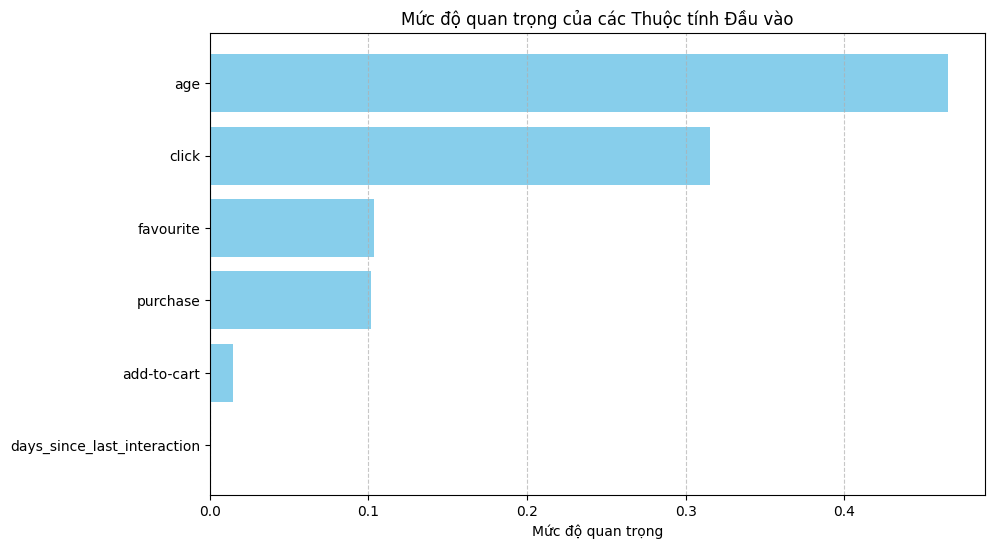

Dựa trên phân tích, 3 thuộc tính quan trọng nhất là: ['age', 'click', 'favourite']


In [3]:
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    input_features = ['age', 'days_since_last_interaction', 'click', 'purchase', 'add-to-cart', 'favourite']
    output_feature = 'label'
    
    X = df[input_features].values
    y = df[output_feature].values

    model.fit(X, y)
    
    print("\n--- Mức độ quan trọng của các thuộc tính ---")
    
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Thuộc tính': input_features,
        'Mức độ quan trọng': importances
    })
    
    feature_importance_df = feature_importance_df.sort_values(by='Mức độ quan trọng', ascending=False)
    
    print(feature_importance_df)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Thuộc tính'], feature_importance_df['Mức độ quan trọng'], color='skyblue')
    plt.xlabel('Mức độ quan trọng')
    plt.title('Mức độ quan trọng của các Thuộc tính Đầu vào')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    top_features = feature_importance_df.head(3)['Thuộc tính'].tolist()
    print(f"Dựa trên phân tích, 3 thuộc tính quan trọng nhất là: {top_features}")

In [4]:
class GaussianFuzzyLayer(keras.layers.Layer):
    def __init__(self, n_memb, mu_initializer, sigma_initializer, **kwargs):
        super().__init__(**kwargs)
        self.m = n_memb # Số hàm thuộc
        self.mu_initializer = mu_initializer
        self.sigma_initializer = sigma_initializer

    def build(self, batch_input_shape):
        self.n = batch_input_shape[-1] # Số thuộc tính đầu vào
        
        # Khởi tạo các tham số mu và sigma
        self.mu = self.add_weight(name='mu',
                                  shape=(self.m, self.n),
                                  initializer=self.mu_initializer,
                                  trainable=True)
        self.sigma = self.add_weight(name='sigma',
                                     shape=(self.m, self.n),
                                     initializer=self.sigma_initializer,
                                     trainable=True)
        super().build(batch_input_shape)

    def call(self, x_inputs):
        x_inputs_tiled = tf.tile(x_inputs, (1, self.m))
        x_inputs_reshaped = tf.reshape(x_inputs_tiled, (-1, self.m, self.n))
        
        # Công thức hàm liên thuộc Gaussian
        output = tf.exp(-1 * tf.square(x_inputs_reshaped - self.mu) / (tf.square(self.sigma) + 1e-7))
        return output

In [5]:
def initialize_params_with_kmeans(X_train, n_memb):
    n_input = X_train.shape[1]
    mu_list, sigma_list = [], []
    for i in range(n_input):
        feature_data = X_train[:, i]
        unique_values = np.unique(feature_data)
        if len(unique_values) < n_memb:
            min_val, max_val = np.min(feature_data), np.max(feature_data)
            mus = np.linspace(min_val, max_val, n_memb)
            sigma_val = (max_val - min_val) / (2 * (n_memb - 1)) if n_memb > 1 and max_val != min_val else 0.1
            sigmas = np.full(n_memb, sigma_val)
        else:
            feature_data_reshaped = feature_data.reshape(-1, 1)
            kmeans = KMeans(n_clusters=n_memb, random_state=42, n_init='auto').fit(feature_data_reshaped)
            mus = kmeans.cluster_centers_.flatten()
            sigmas = [np.std(feature_data[kmeans.labels_ == j]) + 1e-7 if len(feature_data[kmeans.labels_ == j]) >= 2 else np.std(feature_data)/n_memb + 1e-7 for j in range(n_memb)]
        sorted_indices = np.argsort(mus)
        mu_list.append(mus[sorted_indices])
        sigma_list.append(np.array(sigmas)[sorted_indices])
    return tf.constant_initializer(np.array(mu_list).T), tf.constant_initializer(np.array(sigma_list).T)


2025-06-15 07:27:20.348850: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


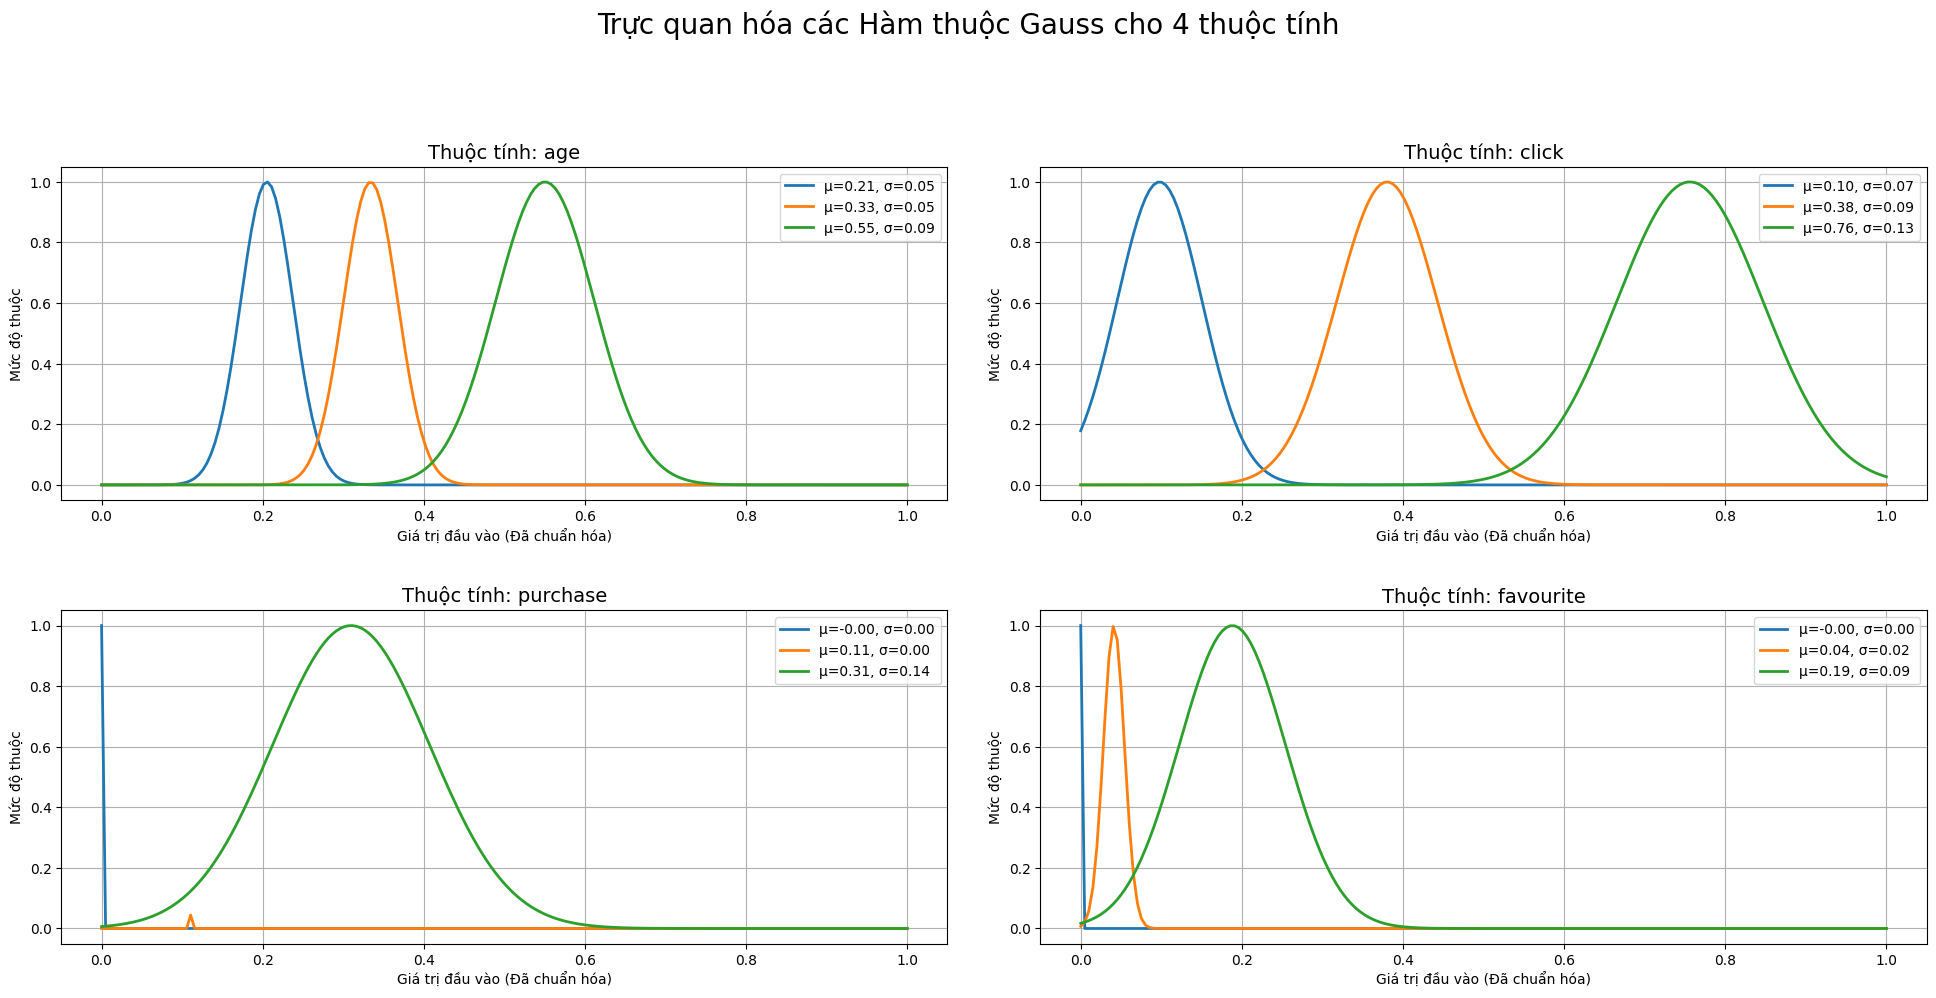

In [6]:
def visualize_gauss():
    feature_names = ['age', 'click', 'purchase', 'favourite']
    
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df[feature_names])

    N_MEMB = 3
    N_INPUTS = len(feature_names)
    mu_list = []
    sigma_list = []

    for i in range(N_INPUTS):
        feature_data = X_scaled[:, i].reshape(-1, 1)
        
        kmeans = KMeans(n_clusters=N_MEMB, random_state=42, n_init='auto').fit(feature_data)
        
        mus = kmeans.cluster_centers_.flatten()
        sigmas = []
        for j in range(N_MEMB):
            cluster_points = X_scaled[:, i][kmeans.labels_ == j]
            if len(cluster_points) < 2:
                sigma_val = np.std(X_scaled[:, i]) / N_MEMB
            else:
                sigma_val = np.std(cluster_points)
            sigmas.append(sigma_val + 1e-7)

        sorted_indices = np.argsort(mus)
        mu_list.append(mus[sorted_indices])
        sigma_list.append(np.array(sigmas)[sorted_indices])

    mu_init_values = np.array(mu_list).T
    sigma_init_values = np.array(sigma_list).T

    fuzzy_layer = GaussianFuzzyLayer(
        n_memb=N_MEMB,
        mu_initializer=tf.constant_initializer(mu_init_values),
        sigma_initializer=tf.constant_initializer(sigma_init_values)
    )
    dummy_input = tf.zeros((1, N_INPUTS), dtype=tf.float32)
    _ = fuzzy_layer(dummy_input)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
    fig.suptitle('Trực quan hóa các Hàm thuộc Gauss cho 4 thuộc tính', fontsize=20, y=1.02)
    
    x_range = np.linspace(0, 1, 200).astype(np.float32)

    for i, ax in enumerate(axes.flatten()):
        plot_input = np.zeros((len(x_range), N_INPUTS), dtype=np.float32)
        plot_input[:, i] = x_range
        
        membership_values = fuzzy_layer(plot_input).numpy()

        for j in range(N_MEMB):
            mu_val = mu_init_values[j, i]
            sigma_val = sigma_init_values[j, i]
            ax.plot(x_range, membership_values[:, j, i], label=f'μ={mu_val:.2f}, σ={sigma_val:.2f}', lw=2)
        
        ax.set_title(f'Thuộc tính: {feature_names[i]}', fontsize=14)
        ax.set_xlabel('Giá trị đầu vào (Đã chuẩn hóa)', fontsize=10)
        ax.set_ylabel('Mức độ thuộc', fontsize=10)
        ax.legend()
        ax.grid(True)

    plt.tight_layout(pad=3.0)
    plt.show()


if __name__ == '__main__':
    visualize_gauss()


In [7]:
class FullCombinationRuleLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, firing_strengths_per_feature):
        rules = firing_strengths_per_feature[:, :, 0]
        n_input = firing_strengths_per_feature.shape[2]
        
        if n_input is None:
            n_input = tf.shape(firing_strengths_per_feature)[2]

        for i in range(1, n_input):
            current_mfs = firing_strengths_per_feature[:, :, i]
            rules_exp = tf.expand_dims(rules, axis=2)
            mfs_exp = tf.expand_dims(current_mfs, axis=1)
            combined = rules_exp * mfs_exp
            rules = tf.reshape(combined, (tf.shape(rules)[0], -1))
            
        return rules

In [8]:
class NormLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, w):
        w_sum = tf.reshape(tf.reduce_sum(w, axis=1), (-1, 1))
        w_norm = w / (w_sum + tf.keras.backend.epsilon())
        return w_norm

In [9]:
class DefuzzLayer(keras.layers.Layer):
    def __init__(self, n_rules, **kwargs):
        super().__init__(**kwargs)
        self.n_rules = n_rules

    def build(self, batch_input_shape):
        w_norm_shape, x_inputs_shape = batch_input_shape
        n_input = x_inputs_shape[-1]
        self.consequence_params = self.add_weight(name='consequence_params',
                                                  shape=(n_input + 1, self.n_rules),
                                                  initializer=keras.initializers.RandomUniform(minval=-1, maxval=1),
                                                  trainable=True)
        super().build(batch_input_shape)

    def call(self, inputs):
        w_norm, x_inputs = inputs
        x_inputs_with_bias = tf.concat([x_inputs, tf.ones((tf.shape(x_inputs)[0], 1))], axis=1)
        rule_outputs = tf.matmul(x_inputs_with_bias, self.consequence_params)
        weighted_rule_outputs = tf.multiply(w_norm, rule_outputs)
        return weighted_rule_outputs

In [10]:
class SummationLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, input_):
        output = tf.reduce_sum(input_, axis=1, keepdims=True)
        return output

In [11]:
def build_anfis_model(n_input, n_memb, mu_init, sigma_init):
    n_rules = n_memb ** n_input
    x_inputs = keras.Input(shape=(n_input,), name="input_features")
    fuzzy_layer_output = GaussianFuzzyLayer(n_memb, mu_init, sigma_init, name="fuzzy_layer")(x_inputs)
    rule_layer_output = FullCombinationRuleLayer(name="rule_layer")(fuzzy_layer_output)
    norm_layer_output = NormLayer(name="norm_layer")(rule_layer_output)
    defuzz_layer_output = DefuzzLayer(n_rules, name="defuzz_layer")([norm_layer_output, x_inputs])
    summation_layer_output = SummationLayer(name="summation_layer")(defuzz_layer_output)
    return keras.Model(inputs=x_inputs, outputs=summation_layer_output, name=f"anfis_kmeans_{n_rules}_rules_model")

In [12]:
input_features = ['age', 'click', 'favourite', 'purchase']
output_feature = 'label'
    
X_full = df[input_features]
y_full = df[output_feature]

X_train_full, X_test, y_train_full, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

train_df = pd.concat([X_train_full, y_train_full], axis=1)

majority_df = train_df[train_df[output_feature] == 0]
minority_df = train_df[train_df[output_feature] == 1]

print(f"Số mẫu lớp đa số (0): {len(majority_df)}")
print(f"Số mẫu lớp thiểu số (1): {len(minority_df)}")

minority_upsampled = resample(minority_df,
                              replace=True,   
                              n_samples=len(majority_df), 
                              random_state=42) 

train_df_resampled = pd.concat([majority_df, minority_upsampled])
    
print("\nSau khi over-sampling:")
print(train_df_resampled[output_feature].value_counts())
    
X_train_resampled_df = train_df_resampled[input_features]
y_train_resampled = train_df_resampled[output_feature]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled_df)
X_test_scaled = scaler.transform(X_test)

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_scaled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)


Số mẫu lớp đa số (0): 94227
Số mẫu lớp thiểu số (1): 9026

Sau khi over-sampling:
label
0    94227
1    94227
Name: count, dtype: int64



---Training---
Epoch 1/100
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5058 - loss: 0.6962 - val_accuracy: 0.5261 - val_loss: 0.6807
Epoch 2/100
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5278 - loss: 0.6825 - val_accuracy: 0.5355 - val_loss: 0.6793
Epoch 3/100
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5308 - loss: 0.6819 - val_accuracy: 0.5370 - val_loss: 0.6788
Epoch 4/100
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5317 - loss: 0.6814 - val_accuracy: 0.5356 - val_loss: 0.6785
Epoch 5/100
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5312 - loss: 0.6811 - val_accuracy: 0.5334 - val_loss: 0.6784
Epoch 6/100
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5305 - loss: 0.6808 - val_accuracy: 0.5339 - val_loss: 0.6782
Epoch 7/100
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5306 - loss: 0.6807 - val_accuracy: 0.5343 - val_loss: 0.6781
Epoch 8/100
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy:

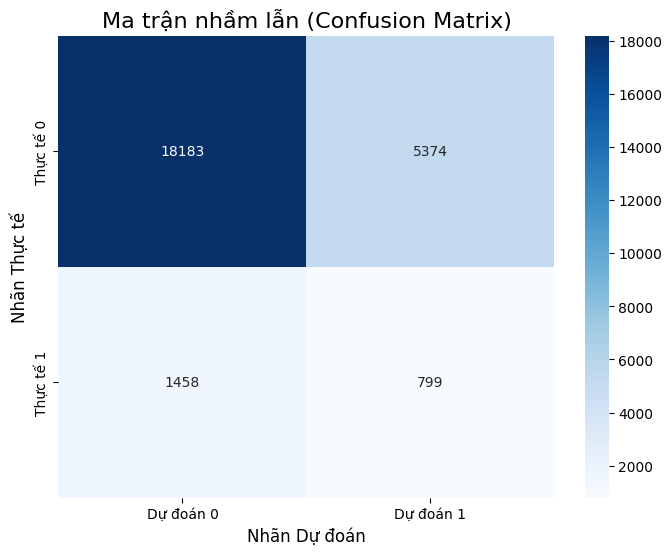

Precision: 0.1294
Recall: 0.3540
F1-score: 0.1896

---Trực quan hóa kết quả huấn luyện---


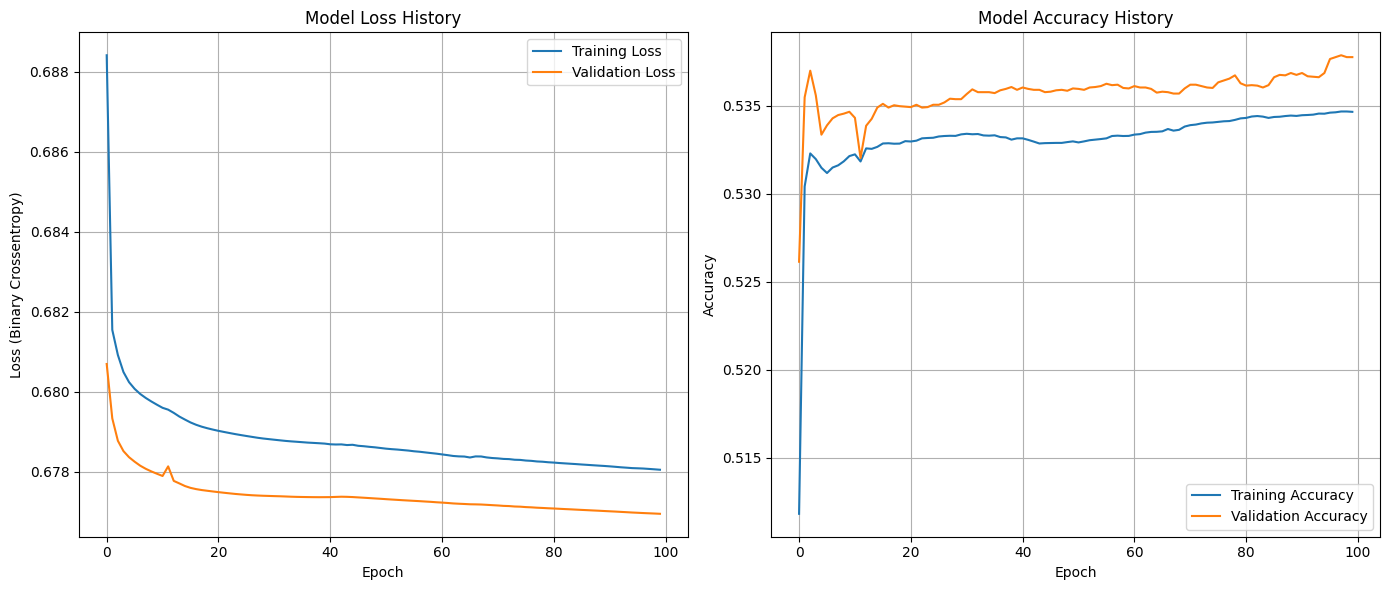

In [13]:
    np.random.seed(42)
    tf.random.set_seed(42)
    
    N_INPUTS = X_train_final.shape[1]
    N_MEMB = 3

    mu_init, sigma_init = initialize_params_with_kmeans(X_train_final, N_MEMB)
    
    anfis = build_anfis_model(N_INPUTS, N_MEMB, mu_init, sigma_init)
    
    anfis.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    # anfis.summary()

    # class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    # class_weights_dict = dict(enumerate(class_weights))
    # print(f"Trọng số lớp: {class_weights_dict}")

    print("\n---Training---")
    history = anfis.fit(X_train_final, y_train_final, 
                          epochs=100, 
                          batch_size=64,
                          verbose=1, 
                          validation_data=(X_val, y_val))
    
    print("\n---Đánh giá mô hình---")
    test_loss, test_accuracy = anfis.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    y_pred_logits = anfis.predict(X_test_scaled)
    y_pred_probs = tf.sigmoid(y_pred_logits).numpy().flatten()
    y_pred_class = (y_pred_probs > 0.5410).astype(int)

    cm = confusion_matrix(y_test, y_pred_class)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Dự đoán 0', 'Dự đoán 1'], 
                yticklabels=['Thực tế 0', 'Thực tế 1'])
    plt.title('Ma trận nhầm lẫn (Confusion Matrix)', fontsize=16)
    plt.ylabel('Nhãn Thực tế', fontsize=12)
    plt.xlabel('Nhãn Dự đoán', fontsize=12)
    plt.show()

    precision = precision_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    print("\n---Trực quan hóa kết quả huấn luyện---")
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Binary Crossentropy)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()